In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 불러오기
- fashion_mnist는 tr.keras의 datasets에 이미 들어있어 `load_data()`로 불러오기만 하면 됨
- 28x28(각 픽셀은 0~255사이의 정숫값을 가짐)
- train : 60,000장 / test : 10,000장

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max(), "\ min pixel:", train_x.min())

max pixel: 255 \ min pixel: 0


각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠준다.

In [4]:
train_x = (train_x - 127.5)/127.5  # 이미지를 [-1, 1]로 정규화
print("max pixel:", train_x.max(), "\ min pixel:", train_x.min())

max pixel: 1.0 \ min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

딥러닝에서 이미지를 다루려면 **채널 수**에 대한 차원이 필요하다.  
입력되는 이미지의 채널 수는 어떤 이미지냐에 따라 달라지는데, 컬러일 경우에는 RGB 세 개의 채널이 있고, 흑백일 경우 1개의 채널만 존재한다.  
fashion MNIST 데이터는 흑백이미지이므로 채널 값은 1이 되므로, 데이터셋의 shape 마지막에 1을 추가해준다.

In [6]:
# reshape(1차원, 2차원, 3차원, 4차원) = reshape(60000,28,28,1)
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

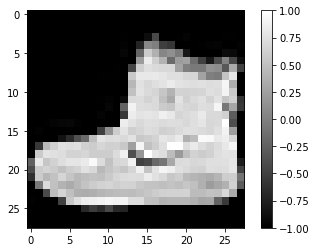

In [7]:
# 첫번째 데이터로 이미지 확인
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()  # 오른쪽에 각 픽셀의 값과 그에 따른 색 확인
plt.show()
# -1이 가장 어두운 검은색, 1이 가장 밝은 흰색

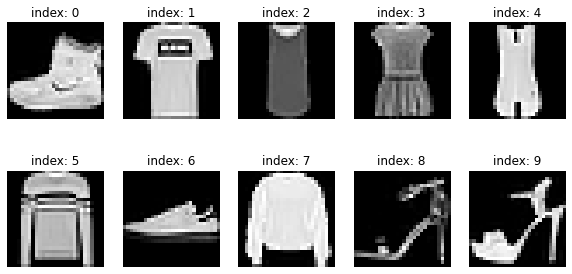

In [8]:
# 10개 이미지 확인
plt.figure(figsize=(10, 5))  # 이미지의 전체 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [9]:
# buffer_size : 어느 정도 섞기 위한 양(60000은 전체데이터를 섞기위함)
# batch_size : 모델이 한 번에 학습할 양
# from_tensor_slices() : list, numpy, tensor자료형에서 데이터셋을 만들 수 있음

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<br><br><br><br><br>

# 생성자 구현
**Conv2DTranspose**  
Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다. 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나간다. 여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일하다.

**BatchNormalization**  
신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다.

**LeakyReLU**  
중간층들의 활성화함수로 사용하였다.

**tanh**  
마지막층의 활성화함수로 사용하였는데, 이는 -1~1이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함이다.

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

- 생성자의 입력 벡터 형태 : (batch_size, 100)
- 첫 레이어 : dense layer
- 첫 레이어를 거친 후 shape : (batch_size, 12544)  # 7x7x256=12544
- 그 다음 레이어 : reshape layer, 그 후의 conv레이어에서 연산이 가능하도록 1차원 벡터를 (7,7,256)형상의 3차원벡터로 변환시켜준다.


In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

(1, 28, 28, 1)


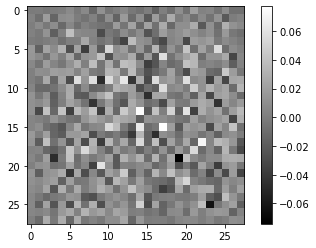

In [13]:
# test - random noise vector(shape = (1,100))
noise = tf.random.normal([1,100])

# tf2.0 version - call method
# 생성자 모델에 입력값으로 noise를 넣고 바로 모델을 호출시키면 간단한 결과 이미지가 생성됨
# 지금은 test이고 학습하는 중이 아니니, training=False를 해주어야함.
# Batch Normalization 레이어는 훈련시기와 추론시기의 행동이 다르기때문에 training=False를 주어야 올바른 결과를 얻을 수 있음
generated_image = generator(noise, training=False)
print(generated_image.shape)
# 첫번째 1 - 1개(batch_size=1)
# 그 뒤 28,28,1 - (28,28,1)사이즈의 이미지가 생성되었다는 뜻

# 이미지 시각화
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# 학습하지 않은 상태이기 때문에 아무런 의미없는 노이즈같은 이미지가 생성됨을 확인할 수 있음

<br><br><br><br><br>

# 판별자 구현
가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력  
- input : (28, 28, 1) image
- output : 1개의 float(진짜라고 판단하는 정도)

**Conv2D**  
`Conv2DTranspose`층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 `Conv2D`층으로 이미지의 크기를 점점 줄여나간다.  
- 입력 : (28,28,1)
- (28,28,1) → (14,14,64) → (7,7,128)

**Flatten**  
3차원 이미지를 1차원으로 쭉 펴서 7*7*128 = 6272, 즉 (1,6272) 벡터로 변환  
이는 생성자의 `Reshape`층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대되는 역할  

**Dense**  
단 하나의 값 출력

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [16]:
# 아까 생성했던 가짜 이미지 판별해보기
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00090882]], dtype=float32)>

<br><br><br><br><br>

# 손실 함수 loss function
- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.
- 교차 엔트로피는 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰인다.
- 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스간 분류문제를 풀어야하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다.
- BinaryCrossEntropy(from_logits=True) : BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid함수를 사용해 0-1사이 값으로 정규화 후 알맞게 계산할 수 있음
  
  
라벨
- 1 : real image
- 0 : fake image

목표  
- 생성자의 목표 : 판별자가 fake img에 대해 판별한 값이 1에 가까워지는 것
- 판별자의 목표 : real img는 1에, fake img는 0에 가까워지는 것  

In [17]:
# BinaryCrossEntropy 클래스는 기본적으로 인풋값이 0-1 사이에 분포하는 확률값이라고 가정
# 그래서 from_logits = True로 설정해주어야 입력된 값을 함수 내부에서
# sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss
- fake_output : 생성자가 생성한 fake image를 구분자에 입력시켜 판별된 값 
- real_output : 기존에 있던 real image를 구분자에 입력시켜 판별된 값

### generator_loss
generator_loss는 fake_output가 1에 가까워지기를 바라므로,  
`cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다.  
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy
**real_output과 fake_output을 얼마나 잘 판별하는지의 정확도**  
만약 이 정확도가 1에 가깝다면 그다지 좋은 뜻은 아니다.  
fake_output이 real_output과 차이가 많이 나기때문에 판별자가 매우 쉽게 구별해내고 있다는 뜻  
즉, real_accuracy, fake_accuracy는 초반 1에 가깝게 나오다가  
서서히 낮아져 0.5에 가까워지는 것이 이상적이다.   

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])

1) `tf.math.greater_equal(real_output, tf.constant([0.5]))`  
real_output의 각 원소가 0.5이상인지 T/F로 판별, `tf.Tensor([False, False, True, True])`

2) `tf.cast( (1), tf.float32)`  
1의 결과가 True이면 1.0, False이면 0.0으로 변환

3) `tf.reduce_mean(2`  
2의 결과를 평균내어 이번 배피의 정확도를 계산

<br><br><br><br><br>

# 최적화 함수 optimizer
https://sacko.tistory.com/42  

Adam 최적화 기법 활용
- 학습의 품질을 올려보고 싶다면 learning rate를 바꾸어가며 학습 진행히보기
- 생성자와 구분자는 따로따로 학습을 진행하는 개별네트워크이기 때문에, optimizer를 따로 만들어주어야 한다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)   # learning_rate=0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것
# 샘플은 한 번에 16장을 생성
# 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.
# 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만듬
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

<br><br><br><br><br>

# 훈련과정 설계

- 하나의 미니배치 당 진행할 train_step 함수 생성
- `@tf.function` 데코레이터
  - session을 열어서 학습했다가 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해주는 데코레이터
  - 함수의 input을 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
(7) accuracy 계산 : fake_output, real_output으로 discriminator가  
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  

In [24]:
# 위 단계를 일정 간격으로 학습현황을 볼 수 있는 샘플을 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # 시각화된 이미지 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [25]:
# train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상
# 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

**checkpoint**  
`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다. 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수이다. 중간에 네트워크가 끊기거나, 모델을 잃어버릴 수도 있으니깐.

In [26]:
# checkpoint에 optimizer와 생성자, 구분자를 모두 넣어 저장
# 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장

# checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 정리
- `train_step` : 한 단계 학습
- `generate_and_save_images()` : 샘플 이미지를 생성하고 저장
- `draw_train_history()` : 학습 과정을 시각화
- `checkpoint` : 모델 저장

<br><br><br><br><br>

# 모델 학습

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

- save_every : 모델을 저장하는 간격
- epochs : 전체 학습 에포크 결정

In [28]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

<br><br><br><br><br>

# 학습과정 시각화하기

- imageio 라이브러리 활용
- `imageio.get_writer`를 활용해서 파일을 열고, 거기에 `append_data`로 이미지를 하나씩 붙여나가는 방식

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif